# Imports

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from isodisreg import idr

import matplotlib.pyplot as plt

from weatherbench2.visualization import set_wb2_style
from weatherbench2.metrics import _spatial_average

import time
from tqdm import tqdm
import concurrent.futures
import multiprocessing

import random
from scipy.stats import gamma

In [2]:
set_wb2_style()

In [3]:
plt.rcParams.update({'font.size': 28})

In [4]:
def calc_spatial_avg_metrics(df):
    
    df_mi = df.set_index(['latitude', 'longitude', 'lead_time'])
    columns_to_include = df_mi.columns
    
    # Create xarray Dataset for all specified columns
    ds_result = xr.Dataset({
        column: (['lead_time', 'latitude', 'longitude'], df_mi[column].values.reshape((-1, len(df_mi.index.levels[0]), len(df_mi.index.levels[1]))))
        for column in columns_to_include
    }, coords={ 
        'latitude': df_mi.index.levels[0], 
        'longitude': df_mi.index.levels[1],
        'lead_time': df_mi.index.levels[2]
    })
    
    # Calculate spatial average for each metric
    spatial_avg_metrics = xr.Dataset()
    spatial_avg_metrics = _spatial_average(ds_result)
    
    return ds_result, spatial_avg_metrics

In [5]:
def get_points(predictions):
    return np.array(predictions.points)
def get_cdf(predictions):
    return np.array(predictions.ecdf)
def modify_points(points):
    return np.hstack([points[0], np.diff(points)])
def var0_se0(w, x, obs):
    first_moment = np.sum(x*w)
    second_moment = np.sum(x**2*w)
    variance = second_moment - first_moment**2
    se = (first_moment - obs)**2
    return variance, se, first_moment

def cal_var_se(preds, obs):
    p = list(map(get_cdf, preds))
    w = list(map(modify_points, p))
    x = list(map(get_points, preds))
    
    return list(map(var0_se0, w, x, obs))

In [ ]:
def process_location(lat, lon, lead_time):
    try:
        forecast_subset = forecast.sel(latitude=lat, longitude=lon, prediction_timedelta=lead_time)

        # Split forecast data into training and test sets
        forecast_train = xr.concat([forecast_subset.sel(time=slice(None, '2019-12-31')),
                                 forecast_subset.sel(time=slice('2021-01-01', obs.time[-1] - pd.to_timedelta(lead_time)))], dim='time')
        forecast_test = forecast_subset.sel(time=slice('2020-01-01', '2020-12-31'))

        # Load ERA5 data
        obs_train = obs.sel(latitude=lat, longitude=lon, time=forecast_train.time + lead_time)
        obs_test = obs.sel(latitude=lat, longitude=lon, time=forecast_test.time + lead_time)

        # Extract values from datasets
        forecast_train_values = forecast_train.values
        forecast_test_values = forecast_test.values
        obs_train_values = obs_train.values
        obs_test_values = obs_test.values

        # Fit IDR
        fitted_idr = idr(obs_train_values, pd.DataFrame({"forecast": forecast_train_values}))

        # Predict 
        #preds_train = fitted_idr.predict(pd.DataFrame({"forecast": forecast_train_values}, columns=["forecast"]))
        preds_test = fitted_idr.predict(pd.DataFrame({"forecast": forecast_test_values}))

        medians_idr = preds_test.qpred(0.5)

        var_idr, mse_idr, _ = np.mean(cal_var_se(preds_test.predictions, obs_test_values), axis=0)

        # Calculate IDR CRPS, MAE and MSE for deterministic forecast
        crps_idr = np.mean(preds_test.crps(obs_test_values))
        mae_idr = np.mean(np.abs(medians_idr - obs_test_values)) #
        mae_det = np.mean(np.abs(forecast_test_values - obs_test_values))
        mse_det = np.mean((forecast_test_values - obs_test_values)**2)

        return {
            'latitude': lat,
            'longitude': lon,
            'lead_time': lead_time,
            'crps_idr': crps_idr,
            'mae_idr': mae_idr, #
            'mse_idr': mse_idr,
            'mae_det': mae_det,
            'mse_det': mse_det,
            'var_idr': var_idr
        }
        
    except Exception as e:
        print(f"Error in process_location for lat={lat}, lon={lon}, lead_time={lead_time}: {e}")
        return None

# Pangu

In [5]:
start_time = time.time()

# Load PANGU data
forecast = xr.open_zarr('gs://weatherbench2/datasets/pangu/2018-2022_0012_64x32_equiangular_conservative.zarr')['temperature'].sel(level=850)
forecast = forecast.compute()
forecast_done_time = time.time() - start_time
print('Forecast done in {:.2f} seconds'.format(forecast_done_time))


start_time = time.time()
# Load ERA5 data
obs = xr.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-64x32_equiangular_conservative.zarr')['temperature'].sel(level=850, time=slice(forecast.time[0], forecast.time[-1]))
obs = obs.compute()

obs_done_time = time.time() - start_time
print('Obs done in {:.2f} seconds'.format(obs_done_time))

Forecast done in 217.82 seconds
Obs done in 6.38 seconds


In [6]:
result_list = []

# Automatically determine the number of workers based on CPU cores
num_workers = int(multiprocessing.cpu_count() * 0.5)

with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor, tqdm(total=len(forecast.prediction_timedelta.values) * len(forecast.latitude.values) * len(forecast.longitude.values)) as pbar:
    futures = []
    for lead_time in forecast.prediction_timedelta.values:
        for lat in forecast.latitude.values:
            for lon in forecast.longitude.values:
                future = executor.submit(process_location, lat, lon, lead_time)
                futures.append(future)

    # Wait for all futures to complete
    for future in concurrent.futures.as_completed(futures):
        result_list.append(future.result())
        pbar.update(1)

executor.shutdown(wait=True)

# Convert the list of dictionaries to a DataFrame
result_df = pd.DataFrame(result_list)

100%|███████████████████████████████████| 81920/81920 [1:18:36<00:00, 17.37it/s]


In [8]:
result_df.sort_values(by=['lead_time', 'latitude', 'longitude']).to_pickle('EasyUQ/pangu_2020_local.pkl')

In [9]:
result = pd.read_pickle('EasyUQ/pangu_2020_local.pkl')

# HRES

In [69]:
start_time = time.time()

# Load HRES data
forecast = xr.open_zarr('gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr')['temperature'].sel(level=850)
forecast = forecast.compute()
forecast_done_time = time.time() - start_time
print('Forecast done in {:.2f} seconds'.format(forecast_done_time))


start_time = time.time()
# Load Analysis data
obs = xr.open_zarr('gs://weatherbench2/datasets/hres_t0/2016-2022-6h-64x32_equiangular_conservative.zarr')['temperature'].sel(level=850, time=slice(forecast.time[0], None))
obs = obs.compute()

obs_done_time = time.time() - start_time
print('Obs done in {:.2f} seconds'.format(obs_done_time))

Forecast done in 617.94 seconds
Obs done in 8.40 seconds


In [70]:
result_list = []

# Automatically determine the number of workers based on CPU cores
num_workers = int(multiprocessing.cpu_count() * 0.5)

with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor, tqdm(total=len(forecast.prediction_timedelta.values) * len(forecast.latitude.values) * len(forecast.longitude.values)) as pbar:
    futures = []
    for lead_time in forecast.prediction_timedelta.values:
        for lat in forecast.latitude.values:
            for lon in forecast.longitude.values:
                future = executor.submit(process_location, lat, lon, lead_time)
                futures.append(future)

    # Wait for all futures to complete
    for future in concurrent.futures.as_completed(futures):
        result_list.append(future.result())
        pbar.update(1)

executor.shutdown(wait=True)

# Convert the list of dictionaries to a DataFrame
result_df = pd.DataFrame(result_list)

100%|█████████████████████████████████████| 83968/83968 [57:25<00:00, 24.37it/s]


In [72]:
result_df.sort_values(by=['lead_time', 'latitude', 'longitude']).to_pickle('EasyUQ/hres_2020_local.pkl')

In [73]:
result = pd.read_pickle('EasyUQ/hres_2020_local.pkl')

# GraphCast

In [5]:
start_time = time.time()

# Load GraphCast data
forecast = xr.concat([xr.open_zarr('gs://weatherbench2/datasets/graphcast/2018/date_range_2017-11-16_2019-02-01_12_hours-64x32_equiangular_conservative.zarr'), xr.open_zarr('gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours-64x32_equiangular_conservative.zarr')],dim='time')['temperature'].sel(level=850)
forecast = forecast.compute()
forecast_done_time = time.time() - start_time
print('Forecast done in {:.2f} seconds'.format(forecast_done_time))


start_time = time.time()
# Load ERA5 data
obs = xr.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-64x32_equiangular_conservative.zarr')['temperature'].sel(level=850, time=slice(forecast.time[0], forecast.time[-1]))
obs = obs.compute()

obs_done_time = time.time() - start_time
print('Obs done in {:.2f} seconds'.format(obs_done_time))

Forecast done in 181.08 seconds
Obs done in 5.12 seconds


In [6]:
result_list = []

# Automatically determine the number of workers based on CPU cores
num_workers = int(multiprocessing.cpu_count() * 0.75)

with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor, tqdm(total=len(forecast.prediction_timedelta.values) * len(forecast.latitude.values) * len(forecast.longitude.values)) as pbar:
    futures = []
    for lead_time in forecast.prediction_timedelta.values:
        for lat in forecast.latitude.values:
            for lon in forecast.longitude.values:
                future = executor.submit(process_location, lat, lon, lead_time)
                futures.append(future)

    # Wait for all futures to complete
    for future in concurrent.futures.as_completed(futures):
        result_list.append(future.result())
        pbar.update(1)

executor.shutdown(wait=True)

# Convert the list of dictionaries to a DataFrame
result_df = pd.DataFrame(result_list)

100%|█████████████████████████████████████| 81920/81920 [17:26<00:00, 78.30it/s]


In [8]:
result_df.sort_values(by=['lead_time', 'latitude', 'longitude']).to_pickle('EasyUQ/graphcast_2020_local.pkl')

In [9]:
result = pd.read_pickle('EasyUQ/graphcast_2020_local.pkl')

# T2M

## Pangu

In [6]:
start_time = time.time()

# Load forecast data
forecast = xr.open_zarr('gs://weatherbench2/datasets/pangu/2018-2022_0012_64x32_equiangular_conservative.zarr')['2m_temperature']
forecast = forecast.compute()
forecast_done_time = time.time() - start_time
print('Forecast done in {:.2f} seconds'.format(forecast_done_time))


start_time = time.time()
# Load ERA5 data
obs = xr.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-64x32_equiangular_conservative.zarr')['2m_temperature'].sel(time=slice(forecast.time[0], forecast.time[-1]+forecast.prediction_timedelta.max()))
obs = obs.compute()

obs_done_time = time.time() - start_time
print('Obs done in {:.2f} seconds'.format(obs_done_time))

PANGU done in 209.49 seconds
Obs done in 2.33 seconds


In [11]:
result_list = []

# Automatically determine the number of workers based on CPU cores
num_workers = int(multiprocessing.cpu_count() * 0.5)

with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor, tqdm(total=len(forecast.prediction_timedelta.values) * len(forecast.latitude.values) * len(forecast.longitude.values)) as pbar:
    futures = []
    for lead_time in forecast.prediction_timedelta.values:
        for lat in forecast.latitude.values:
            for lon in forecast.longitude.values:
                future = executor.submit(process_location, lat, lon, lead_time)
                futures.append(future)

    # Wait for all futures to complete
    for future in concurrent.futures.as_completed(futures):
        result_list.append(future.result())
        pbar.update(1)

executor.shutdown(wait=True)

# Convert the list of dictionaries to a DataFrame
result_df = pd.DataFrame(result_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81920/81920 [1:17:39<00:00, 17.58it/s]


In [14]:
result_df.sort_values(by=['lead_time', 'latitude', 'longitude']).reset_index(drop=True).to_pickle('EasyUQ/T2M/pangu_2020_local.pkl')

## GraphCast

In [15]:
start_time = time.time()

# Load forecast data
forecast = xr.concat([xr.open_zarr('gs://weatherbench2/datasets/graphcast/2018/date_range_2017-11-16_2019-02-01_12_hours-64x32_equiangular_conservative.zarr'), 
                      xr.open_zarr('gs://weatherbench2/datasets/graphcast/2020/date_range_2019-11-16_2021-02-01_12_hours-64x32_equiangular_conservative.zarr')],
                     dim='time')['2m_temperature']
forecast = forecast.compute()
forecast_done_time = time.time() - start_time
print('forecast done in {:.2f} seconds'.format(forecast_done_time))

start_time = time.time()
# Load ERA5 data
obs = xr.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-64x32_equiangular_conservative.zarr')['2m_temperature'].sel(time=slice(forecast.time[0], forecast.time[-1]+forecast.prediction_timedelta.max()))
obs = obs.compute()

obs_done_time = time.time() - start_time
print('Obs done in {:.2f} seconds'.format(obs_done_time))

forecast done in 118.08 seconds
Obs done in 2.35 seconds


In [16]:
result_list = []

# Automatically determine the number of workers based on CPU cores
num_workers = int(multiprocessing.cpu_count())# * 0.75)

with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor, tqdm(total=len(forecast.prediction_timedelta.values) * len(forecast.latitude.values) * len(forecast.longitude.values)) as pbar:
    futures = []
    for lead_time in forecast.prediction_timedelta.values:
        for lat in forecast.latitude.values:
            for lon in forecast.longitude.values:
                future = executor.submit(process_location, lat, lon, lead_time)
                futures.append(future)

    # Wait for all futures to complete
    for future in concurrent.futures.as_completed(futures):
        result_list.append(future.result())
        pbar.update(1)

executor.shutdown(wait=True)

# Convert the list of dictionaries to a DataFrame
result_df = pd.DataFrame(result_list)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81920/81920 [41:56<00:00, 32.55it/s]


In [17]:
result_df.sort_values(by=['lead_time', 'latitude', 'longitude']).reset_index(drop=True).to_pickle('EasyUQ/T2M/graphcast_2020_local.pkl')

## HRES

In [24]:
start_time = time.time()

# Load HRES data
forecast = xr.open_zarr('gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr')['2m_temperature']
forecast = forecast.compute()
forecast_done_time = time.time() - start_time
print('HRES done in {:.2f} seconds'.format(forecast_done_time))


start_time = time.time()
# Load Analysis data
obs = xr.open_zarr('gs://weatherbench2/datasets/hres_t0/2016-2022-6h-64x32_equiangular_conservative.zarr')['2m_temperature'].sel(time=slice(forecast.time[0], forecast.time[-1]+forecast.prediction_timedelta.max()))
obs = obs.compute()

obs_done_time = time.time() - start_time
print('Obs done in {:.2f} seconds'.format(obs_done_time))

HRES done in 370.15 seconds
Obs done in 2.24 seconds


In [25]:
result_list = []

# Automatically determine the number of workers based on CPU cores
num_workers = int(multiprocessing.cpu_count())# * 0.75)

with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor, tqdm(total=len(forecast.prediction_timedelta.values) * len(forecast.latitude.values) * len(forecast.longitude.values)) as pbar:
    futures = []
    for lead_time in forecast.prediction_timedelta.values:
        for lat in forecast.latitude.values:
            for lon in forecast.longitude.values:
                future = executor.submit(process_location, lat, lon, lead_time)
                futures.append(future)

    # Wait for all futures to complete
    for future in concurrent.futures.as_completed(futures):
        result_list.append(future.result())
        pbar.update(1)

executor.shutdown(wait=True)

# Convert the list of dictionaries to a DataFrame
result_df = pd.DataFrame(result_list)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83968/83968 [1:48:01<00:00, 12.96it/s]


In [26]:
result_df.sort_values(by=['lead_time', 'latitude', 'longitude']).reset_index(drop=True).to_pickle('EasyUQ/T2M/hres_2020_local.pkl')

# Trying Things

## ENS

In [5]:
from properscoring import crps_ensemble

In [6]:
# Lead Time in ns, 6h -> 21600000000000
lead_time = np.timedelta64(12*21600000000000,'ns')

# Load IFS ENS data
ens = xr.open_zarr('gs://weatherbench2/datasets/ens/2018-2022-64x32_equiangular_conservative.zarr')['temperature'].sel(level=850, latitude=47.8125, longitude=5.625, prediction_timedelta=lead_time, method='nearest')
ens = ens.compute()
# Load Analysis data
obs = xr.open_zarr('gs://weatherbench2/datasets/hres_t0/2016-2022-6h-64x32_equiangular_conservative.zarr')['temperature'].sel(level=850, latitude=47.8125, longitude=5.625, method='nearest')
obs= obs.sel(time=slice('2018-01-01',None))
obs = obs.compute()

# Split PANGU data into training and test sets
ens_train = xr.concat([ens.sel(time=slice(None,'2019-12-31')), ens.sel(time=slice('2021-01-01',obs.time[-2] - pd.to_timedelta(lead_time)))], dim='time')
ens_test = ens.sel(time=slice('2020-01-01','2020-12-31'))

# Load ERA5 data
obs_train = obs.sel(time=ens_train.time+lead_time)
obs_test = obs.sel(time=ens_test.time+lead_time)

# Extract values from datasets
ens_train_values = ens_train.values
ens_test_values = ens_test.values
obs_train_values = obs_train.values
obs_test_values = obs_test.values

In [10]:
fitted_idr_icx = idr(y=obs_train_values, X=pd.DataFrame(ens_train_values), orders=dict({"1":"icx"}), max_iter = 1000, eps_rel = 0.0001, eps_abs = 0.0001)

100%|███████████████████████████████████████| 2905/2905 [03:59<00:00, 12.12it/s]


In [12]:
#preds_train = fitted_idr.predict(pd.DataFrame(ens_train_values))
preds_test = fitted_idr_icx.predict(pd.DataFrame(ens_test_values))

#medians
upper = np.argmax(preds_test.cdf(fitted_idr_icx.thresholds) > 0.5, axis=1)
lower = np.full(len(obs_test_values), len(fitted_idr_icx.thresholds)-1) - np.argmax((preds_test.cdf(fitted_idr_icx.thresholds) < 0.5)[:, ::-1],axis=1)

too_low_indices = np.where(preds_test.cdf(fitted_idr_icx.thresholds)[:, 0] >= 0.5)[0]
too_low_array = np.zeros(len(obs_test_values))
too_low_array[too_low_indices] = 1

too_high_indices = np.where(preds_test.cdf(fitted_idr_icx.thresholds)[:, -1] <= 0)[0]
too_high_array = np.zeros(len(obs_test_values))
too_high_array[too_high_indices] = 1

combined_array = np.column_stack((preds_test.cdf(fitted_idr_icx.thresholds), upper, lower, too_low_array, too_high_array))
medians_idr = np.apply_along_axis(calculate_median_threshold, axis=1, arr=combined_array, thresholds=fitted_idr_icx.thresholds)

# Calculate IDR CRPS, MAE and MSE for deterministic forecast
crps_idr = np.mean(preds_test.crps(obs_test_values))
crps_raw = np.mean(crps_ensemble(obs_test, ens_test))
mae_idr = np.mean(np.abs(medians_idr - obs_test_values))
mae_det = np.mean(np.abs(np.median(ens_test_values, axis=1) - obs_test_values))

print(f'CRPS IDR {crps_idr}')
print(f'CRPS Raw {crps_raw}')
print(f'MAE IDR Medians {mae_idr}')
print(f'MAE Raw {mae_det}')

CRPS IDR 0.3975743214123418
CRPS Raw 0.3784606237859674
MAE IDR Medians 0.5402885675430298
MAE Raw 0.5172966122627258


In [ ]:
fitted_idr = idr(y=obs_train_values, X=pd.DataFrame(ens_train_values), orders=dict({"1":"sd"}))

In [ ]:
#preds_train = fitted_idr.predict(pd.DataFrame(ens_train_values))
preds_test = fitted_idr.predict(pd.DataFrame(ens_test_values))

#medians
upper = np.argmax(preds_test.cdf(fitted_idr.thresholds) > 0.5, axis=1)
lower = np.full(len(obs_test_values), len(fitted_idr.thresholds)-1) - np.argmax((preds_test.cdf(fitted_idr.thresholds) < 0.5)[:, ::-1],axis=1)

too_low_indices = np.where(preds_test.cdf(fitted_idr.thresholds)[:, 0] >= 0.5)[0]
too_low_array = np.zeros(len(obs_test_values))
too_low_array[too_low_indices] = 1

too_high_indices = np.where(preds_test.cdf(fitted_idr.thresholds)[:, -1] <= 0)[0]
too_high_array = np.zeros(len(obs_test_values))
too_high_array[too_high_indices] = 1

combined_array = np.column_stack((preds_test.cdf(fitted_idr.thresholds), upper, lower, too_low_array, too_high_array))
medians_idr = np.apply_along_axis(calculate_median_threshold, axis=1, arr=combined_array, thresholds=fitted_idr.thresholds)

# Calculate IDR CRPS, MAE and MSE for deterministic forecast
crps_idr = np.mean(preds_test.crps(obs_test_values))
crps_raw = np.mean(crps_ensemble(obs_test, ens_test))
mae_idr = np.mean(np.abs(medians_idr - obs_test_values))
mae_raw = np.mean(np.abs(np.median(ens_test_values, axis=1) - obs_test_values))

print(f'CRPS IDR {crps_idr}')
print(f'CRPS Raw {crps_raw}')
print(f'MAE IDR Meadians {mae_idr}')
print(f'MAE Raw {mae_raw}')

## Subagging

In [79]:
#import osqp
#from scipy import sparse

# Python code adapted from R Code from Alexander Henzi

def idrbag(y, X, groups=None, orders={1:"comp"}, verbose=False, max_iter=10000, eps_rel=0.00001,
           eps_abs=0.00001, progress=True, newdata=None, digits=3, interpolation="linear", b=None,
           p=None, replace=False, grid=None):
    """
    Compute IDR predictions with (su)bagging.

    Parameters
    ----------
    y : np.array
        One-dimensional array (response variable).
    X : pd.DataFrame
        Data frame of variables (regression covariates).
    groups : dict
        Denoting groups of variables that are to be ordered with the same order.
        Only relevant if X contains more than one variable.
        The default uses one group for all variables.
    orders : dict
        Denotes the order that is applied to a group.
        Only relevant if X contains more than one variable.
        The default is dict({"1":"comp"}).
    verbose : bool
        Print output of OSQP solver. The default is False.
    max_iter : int
        Maximum number of iterations.
    eps_rel : float
        Relative tolerance.
    eps_abs : float
        Absolute tolerance.
    progress : bool
        Show progress bar. The default is True.
    newdata : pd.DataFrame
        Data frame containing variables with which to predict.
    digits : int
        Number of decimal places for the predictive CDF.
    interpolation : str
        Interpolation method for univariate data. Default is "linear".
    b : int
        Number of (su)bagging samples.
    p : float
        Size of (su)bagging samples relative to training data.
    replace : bool
        Draw samples with (True) or without (False) replacement.
    grid : np.array
        Grid on which the predictive CDFs are evaluated. Default are
        the unique values of `y`.

    Returns
    -------
    list
        A list of predictions.

    Notes
    -----
    This function draws `b` times a random subsample of size
    `ceiling(nrow(X)*p)` from the training data, fits IDR to each
    subsample, computes predictions for the new data supplied in `newdata`,
    and averages the predictions derived from the `b` subsamples.
    """
    if not isinstance(X, pd.DataFrame):
        raise ValueError("X must be a pandas data frame")

    if groups is None:
        groups = dict(zip(X.columns, np.ones(X.shape[1])))

    y = np.asarray(y)

    if y.ndim > 1:
        raise ValueError('idr only handles 1-D arrays of observations')

    if X.shape[0] <= 1:
        raise ValueError('X must have more than 1 row')

    if np.isnan(np.sum(y)) == True:
        raise ValueError("y contains nan values")

    if X.isnull().values.any() == True:
        raise ValueError("X contains nan values")

    if y.size != X.shape[0]:
        raise ValueError("length of y must match the number of rows in X")

    if all(item in ['comp', 'icx', 'sd'] for item in orders.values()) == False:
        raise ValueError("orders must be in comp, icx, sd")

    if newdata is not None and not isinstance(newdata, pd.DataFrame):
        raise ValueError("'newdata' must be a pandas data frame")

    N = len(y)

    if b is None or not isinstance(b, int) or b < 1 or b > N:
        raise ValueError("'b' must be a positive integer smaller than length(y)")

    if p is None or not isinstance(p, float) or p <= 0 or p >= 1:
        raise ValueError("'p' must be a number in (0, 1)")

    if isinstance(replace, bool):
        replace = 1 if replace else 0
    elif not isinstance(replace, (int, np.int64)):
        raise ValueError("'replace' must be True/False or 1/0")

    if isinstance(progress, bool):
        progress = 1 if progress else 0
    elif not isinstance(progress, (int, np.int64)):
        raise ValueError("'progress' must be True/False or 1/0")

    if grid is None:
        grid = np.sort(np.unique(y))
    elif not isinstance(grid, np.ndarray) or grid.dtype.type not in [np.float64, np.int64, np.float32]: # added np.float32
        raise ValueError("'grid' must be a numeric array or None")

    n = int(np.ceil(p * N))
    m = len(grid)
    preds = np.zeros((len(newdata), m), dtype=np.float32)
    #crps = np.zeros((len(newy),b))

    for i in tqdm(range(b), disable=not progress):
        s = np.random.choice(N, n, replace=replace)
        ys = y[s]
        ysunique = np.unique(ys)

        if len(ysunique) == 1:
            pos = np.searchsorted(grid, ysunique)
            if pos > 0:
                cdf[:, :pos] += 1
        else:
            fit = idr(y=ys, X=X.iloc[s, :], groups=groups, orders=orders, verbose=verbose,
                      max_iter=max_iter, eps_rel=eps_rel, eps_abs=eps_abs, progress=False)
            preds += fit.predict(data=newdata, digits=digits).cdf(grid)
    
    preds = np.round(preds / b, digits)
    preds = [pd.DataFrame({"points": grid[(dat > 0) & (dat < 1)], "ecdf": dat[(dat > 0) & (dat < 1)]}) for dat in preds]

    return preds

In [37]:
preds = idrbag(obs_train_values, pd.DataFrame({"forecast": pangu_train_values}, columns=["forecast"]), newdata=pd.DataFrame({"forecast": pangu_test_values}, columns=["forecast"]), b=100, p=0.5)

100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.16it/s]


In [38]:
def get_points(predictions):
    return np.array(predictions.points)
def get_cdf(predictions):
    return np.array(predictions.ecdf)
def modify_points(points):
    return np.hstack([points[0], np.diff(points)])
def crps0(y, p, w, x):
    return 2*np.sum(w*(np.array((y<x))-p+0.5*w)*np.array(x-y))

def cal_crps(preds, obs):
    p = list(map(get_cdf, preds))
    w = list(map(modify_points, p))
    x = list(map(get_points, preds))

    return list(map(crps0, obs, p, w, x))

In [39]:
np.mean(cal_crps(preds, obs_test_values))

0.799549310991923

# Simulation Example

In [6]:
# Simulate data
n = 1000
forecast = np.random.uniform(low=0.0, high=10.0, size=n)
y_true = np.random.gamma(shape = np.sqrt(forecast), scale=np.minimum(np.maximum(forecast, 2), 8), size=n)  

In [9]:
# Divide into train and test: 80 / 20
split_ix = int(np.floor(n * 0.8))
ix_data = np.arange(n)
random.shuffle(ix_data)
forecast_train = forecast[:split_ix]
forecast_test = forecast[split_ix:]
y_true_train = y_true[:split_ix]
y_true_test = y_true[split_ix:]

In [10]:
# Fit EasyUQ
fitted_idr = idr(y_true_train, pd.DataFrame({"fore": forecast_train}, columns=["fore"]))
preds_train = fitted_idr.predict(pd.DataFrame({"fore": forecast_train}, columns=["fore"]))
preds_test = fitted_idr.predict(pd.DataFrame({"fore": forecast_test}, columns=["fore"]))

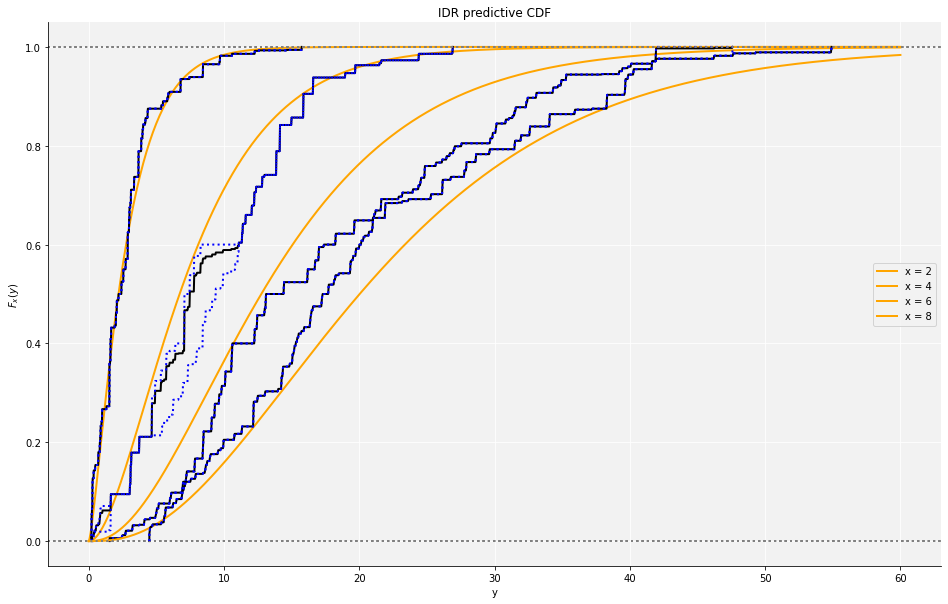

In [11]:
x_bla = np.array([2,4,6,8])
bla = fitted_idr.predict(pd.DataFrame({"fore": x_bla}, columns=["fore"]))

# Parameters of the gamma distribution
shape = np.sqrt(x_bla)  # shape parameter (k)
scale = x_bla  # scale parameter (theta)

# Generate values for x
x = np.linspace(0, 60, 1000)

# Calculate the cumulative distribution function (CDF) values
cdf_values_list = []
for i in range(len(x_bla)):
    cdf_values_list.append(gamma.cdf(x, a=shape[i], scale=scale[i]))

plt.figure(figsize=(16, 10))

# Plot the CDF
for i in range(len(x_bla)):
    plt.plot(x, cdf_values_list[i], label=f'x = {x_bla[i]}', color='orange')
    bla.plot(index=i)

# Get the current Axes instance
ax = plt.gca()

# Find the legend and add a new label for the last line (predictions)
legend = ax.legend()
legend_texts = legend.get_texts()
legend_texts.extend(['bla'])

#plt.title('CDF')
plt.xlabel('y')
plt.ylabel('$F_x(y)$')
plt.legend()
plt.grid(True)
plt.show()

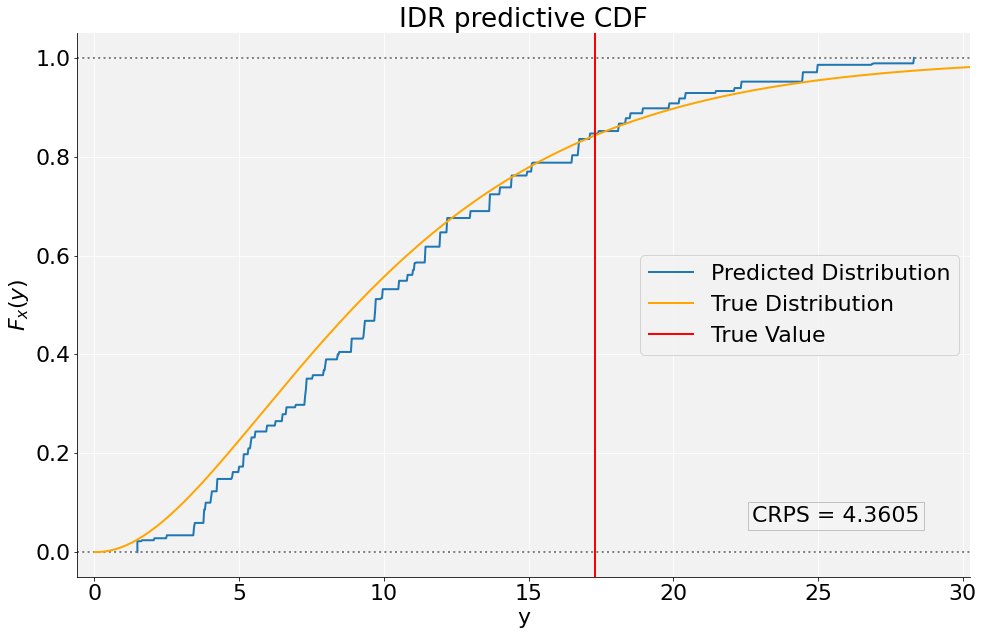

In [21]:
plt.rcParams.update({'font.size': 22})

i=6

plt.figure(figsize=(16, 10))

# Parameters of the gamma distribution
shape = np.sqrt(forecast_test[i])  # shape parameter (k)
scale = forecast_test[i]  # scale parameter (theta)

# Generate values for x
x = np.linspace(0, 60, 1000)

# Calculate the cumulative distribution function (CDF) values
cdf_values = gamma.cdf(x, a=shape, scale=scale)

# Placeholder plot for preds_test[i].plot() with label=None
plt.plot([], [], label='Placeholder')
preds_test.plot(index=i, bounds=False, col_cdf ='C0')

# Get the current Axes instance
ax = plt.gca()

xlim = ax.get_xlim()[1]

# Plot the CDF
plt.plot(x, cdf_values, label=f'True Distribution', color='orange')
plt.axvline(y_true_test[i], label='True Value', color='red')

# Find the legend and add a new label for the last line (predictions)
legend = ax.legend()
legend_texts = legend.get_texts()
legend_texts[0].set_text(f'Predicted Distribution')

# Add CRPS information in a box
crps_value = np.round(preds_test.crps(y_true_test)[i],4)
box_props = dict(facecolor='white', alpha=0.2)
ax.text(0.85, 0.1, f'CRPS = {crps_value}', transform=ax.transAxes, bbox=box_props, ha='center', fontsize=22)

#plt.title('CDF')
plt.xlabel('y')
plt.ylabel('$F_x(y)$')
plt.xlim(-(xlim/50),xlim+(xlim/50))
plt.grid(True)
plt.show()

(array([27., 15., 25., 10., 19., 22., 18., 29., 17., 18.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

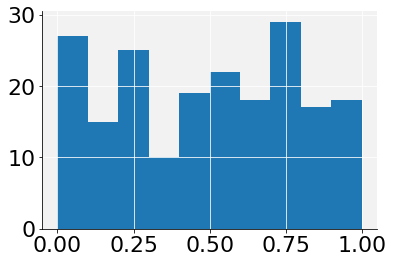

In [13]:
plt.hist(preds_test.pit(y_true_test))

In [14]:
crps_idr = np.mean(preds_test.crps(y_true_test))
print(f'Mean CRPS: {crps_idr}')

Mean CRPS: 4.2525299737314155
